# Basic viscous flow
In this example, we will simulate various examples of a basic *unbounded* viscous flow---a flow
without boundaries. Our initial condition will be a distribution of *vorticity*.

In [1]:
using ViscousFlow

In [2]:
using Plots

### The basic steps
To carry out any simulation in `ViscousFlow`, we need to carry out a few basic steps:
* **Specify the problem**: Set the Reynolds number, the free stream, and any other problem parameters
* **Discretize**: Set up a solution domain, choose the grid Reynolds number and the critical time step limits
* **Construct the system structure**: Create the operators that will be used to perform the simulation
* **Initialize**: Set the initial flow field and initialize the integrator
* **Solve**: Solve the flow field
* **Examine**: Examine the results

We will go through all of these here. For the examples we will carry out in this notebook,
the first two steps need only be carried out once.

The package utilizes parameters arranged into a dictionary, or `Dict`.
The dictionary associates names (or *keys*) with values. Most of these
key have standardizes names. We
will describe the entries in this as we go, adding them in one at a time for
expositional purposes. We initializing it first and call it `my_params`
for this example.

In [3]:
my_params = Dict()

Dict{Any, Any}()

### Problem specification
We will set the Reynolds number to be 200 and no free stream. The
Reynolds number key is "Re". If we had a free stream, then we would
set this with two keys: "freestream speed" and "freestream angle".
They default to zero if we don't put anything into the dictionary.
But we always have to put in the Reynolds number.

In [4]:
my_params["Re"] = 200

200

### Discretize
We will set up a domain from x = -2 to x = 2, and y = -2 to y = 2. The Reynolds number helps us
determine the grid spacing and time step size. To set these, we set a target *grid Reynolds
number*, with the key "grid Re". We will set this to 4 here; if we don't set it, it
defaults to 2. Note that the choice we make here is a compromise:
* smaller grid Reynolds number means smaller grid spacing, but slower simulations
* larger grid Reynolds number means less accurate results

In [5]:
xlim = (-2.0,2.0)
ylim = (-2.0,2.0)
my_params["grid Re"] = 4.0

4.0

Then we set up the grid

In [6]:
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((204, 202), (102, 101), 0.02, ((-2.02, 2.02), (-2.0, 2.0)), 10)

### Construct the system structure
This part is easy - you supply the parameters you have just set up.
It returns a structure with all of the necessary mathematical operators:

In [7]:
sys = viscousflow_system(g,phys_params=my_params);

This is now ready to solve any unbounded viscous flow problems.
Now, we will solve a few different problems to see how it works.

## A basic example: the Lamb-Oseen vortex
This example starts with a single vortex with a Gaussian distribution of vorticity. To generate this, will use the `SpatialGaussian` function:
The command below creates a Gaussian with radius σ at (0,0) with strength 1.

In [8]:
σ = 0.2
x0 = 0.0
y0 = 0.0
A = 1
gauss = SpatialGaussian(σ,x0,y0,A)

SpatialGaussian{false, SpaceTimeFields.ShiftedProfile{Float64, Gaussian}, SpaceTimeFields.ShiftedProfile{Float64, Gaussian}}(Gaussian (σ = 0.2, A = 1.0) >> 0.0, Gaussian (σ = 0.2, A = 1.0) >> 0.0, 1.0, 0.0, 0.0)

### Initialize
Now, we create an instance of this vorticity distribution on the grid by
calling `init_sol` with this vortex.

In [9]:
u0 = init_sol(gauss,sys)

(Dual nodes in a (nx = 204, ny = 202) cell grid of type Float64 data
  Number of Dual nodes: (nx = 204, ny = 202), Float64[])

We use this initial condition to initialize the **integrator**. The integrator is the structure that
holds all of our solution and operator information. With it, we can start the simulation, restart
the simulation later, etc. We specify a range of time over which to advance the solution.

**Note**: This range need only be large enough to contain the whole interval of time we wish to simulate. It does not need to be chosen very precisely.

**Note 2**: There is no need to restart the problem! We can keep applying the `step!` function below as long we need.

In [10]:
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 204, ny = 202) cell grid of type Float64 data
  Number of Dual nodes: (nx = 204, ny = 202), Float64[])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 1$:

In [11]:
step!(integrator,1.0)

We can see now that the solution has been advanced in time:

In [12]:
integrator

t: 1.0000000000000007
u: (Dual nodes in a (nx = 204, ny = 202) cell grid of type Float64 data
  Number of Dual nodes: (nx = 204, ny = 202), Float64[])

### Examine
Let's examine the results. It is important to show a few different ways that we can do this.
The most straightforward way is to just look at the flow fields at the current state of the
integrator. For example, to get the current velocity field, type `velocity(integrator)`. We can
do the same for `vorticity`, `streamfunction` (the streamlines), `scalarpotential`, `convective_derivative`,
and `pressure`.

We will look at some of these at the current state:

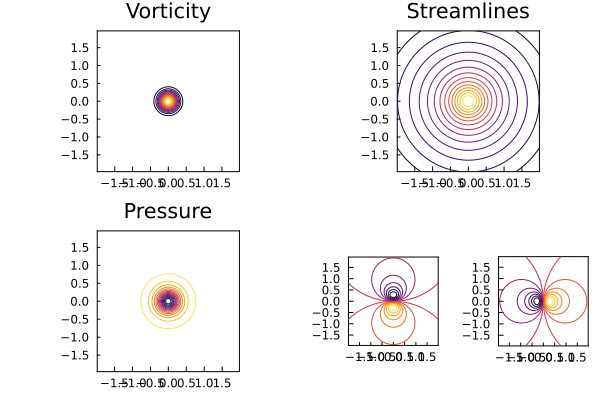

In [13]:
plot(
 plot(vorticity(integrator),sys,title="Vorticity"),
 plot(streamfunction(integrator),sys,title="Streamlines"),
 plot(pressure(integrator),sys,title="Pressure"),
 plot(velocity(integrator),sys))

For this problem, we can compare with the exact solution. The exact solution is also a Gaussian,
but with a radius $\sqrt{\sigma^2+4t/Re}$

In [14]:
oseen_exact(t) = SpatialGaussian(sqrt(σ^2+4*t/my_params["Re"]),x0,y0,A)
exactsol(t) = init_sol(oseen_exact(t),sys)

exactsol (generic function with 1 method)

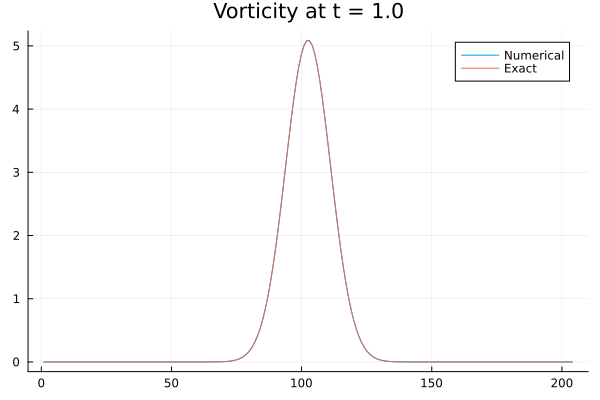

In [15]:
plot(vorticity(integrator)[:,104],label="Numerical")
plot!(vorticity(exactsol(integrator.t),sys,integrator.t)[:,104],label="Exact")
plot!(title=string("Vorticity at t = ",round(integrator.t,digits=2)))

## Second example: co-rotating vortices
The previous example is not very exciting, because the convection of the flow is simply circular.
The next example is more interesting, because we will start with two vortices that influence each
other's motion:

In [16]:
σ = 0.1
x01, y01 = 0.5, 0.0
x02, y02 = -0.5, 0.0
A = 1
twogauss = SpatialGaussian(σ,x01,y01,A) + SpatialGaussian(σ,x02,y02,A)

AddedFields:
  SpatialGaussian{false, SpaceTimeFields.ShiftedProfile{Float64, Gaussian}, SpaceTimeFields.ShiftedProfile{Float64, Gaussian}}(Gaussian (σ = 0.1, A = 1.0) >> 0.5, Gaussian (σ = 0.1, A = 1.0) >> 0.0, 1.0, 0.0, 0.0)
  SpatialGaussian{false, SpaceTimeFields.ShiftedProfile{Float64, Gaussian}, SpaceTimeFields.ShiftedProfile{Float64, Gaussian}}(Gaussian (σ = 0.1, A = 1.0) >> -0.5, Gaussian (σ = 0.1, A = 1.0) >> 0.0, 1.0, 0.0, 0.0)


### Initialize
Now, we create an instance of this vorticity distribution on the grid.

In [17]:
u0 = init_sol(twogauss,sys)

(Dual nodes in a (nx = 204, ny = 202) cell grid of type Float64 data
  Number of Dual nodes: (nx = 204, ny = 202), Float64[])

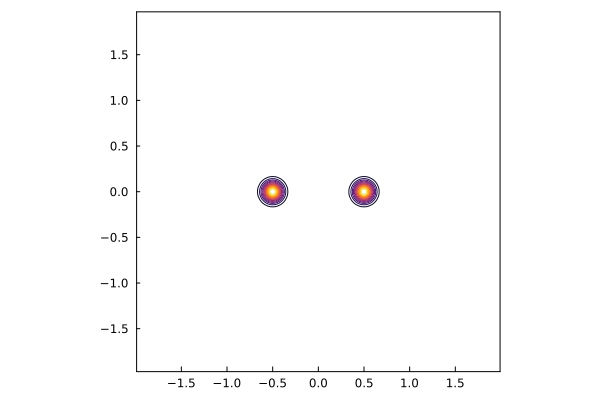

In [18]:
plot(vorticity(u0,sys,0.0),sys)

In [19]:
tspan = (0.0,8.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 204, ny = 202) cell grid of type Float64 data
  Number of Dual nodes: (nx = 204, ny = 202), Float64[])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 8$:

In [20]:
step!(integrator,8.0)

### Examine
In this case, it is best to view the results as an animation. In the previous example, we just
looked at the final state of the integrator. Here, to animate, we will make use of the solution
history that is held by the integrator, `integrator.sol`. Let's create an alias for this to shorten
our commands:

In [21]:
sol = integrator.sol;

The vortices orbit each other and then eventually merge together. If we wish to make a nice
figure, we can arrange snapshots on a grid:

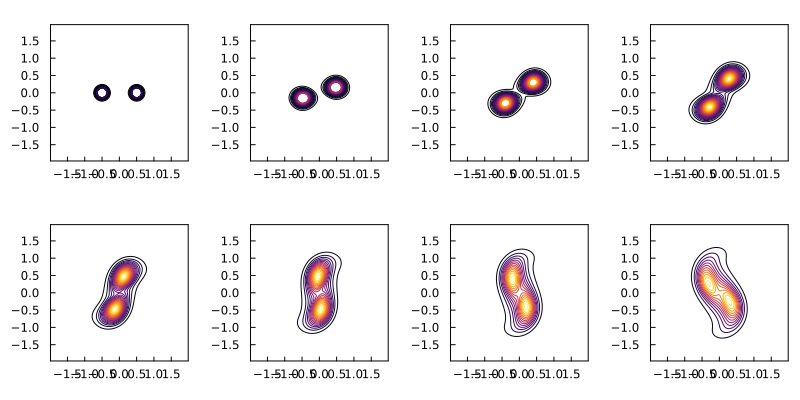

In [22]:
plt = plot(layout = (2,4), size = (800, 400), legend=:false)
tsnap = 0.0:1.0:7.0
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,levels=range(0.1,5,length=31))
end
savefig(plt,"CoRotating.pdf")
plt

If you wish to animate the solution, e.g., plotting the vorticity every 5 steps
you can use

    @gif for t in sol.t
       plot(vorticity(sol,sys,t),sys)
    end every 5

**Try other examples!**
* Make one or both of the vortices into elliptical shapes
* Make one stronger than the other
* Add other vortices into the initial distribution

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*